# Preprocess and window longitudinal datasets and save afterwards

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

In [3]:
from decode_tueg import (
    get_longitudinal_ds, preprocess, get_preprocessors,
    _create_windows, _create_final_scores, load_exp,
    get_n_preds_per_input, DataScaler, TargetScaler,
    Augmenter, iter_exp_dir,
)

Tue Feb 14 15:16:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3E:00.0 Off |                  N/A |
| 27%   26C    P8     9W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
exp_date = '2023-02-09T09:34:21.685021'
exp_dir = '/home/jovyan/experiments/'
mapping = None  # where to get this from?
checkpoint = 'train_end'

In [5]:
for x in iter_exp_dir(exp_dir, exp_date):
    break

In [6]:
estimator, data_scaler, target_scaler, config = load_exp(
    exp_dir, os.path.join(exp_dir, x), checkpoint)

In [7]:
min_age = int(config.min_age)
max_age = int(config.max_age)
tmin = int(config.tmin)
tmax = int(config.tmax)
n_jobs = int(config.n_jobs)
window_size_samples = int(config.window_size_samples)
preload = int(config.preload)
target_name = config.target_name
out_dir = config.out_dir

In [12]:
#'pathological', 'non_pathological', 'transition'
for ds_name in ['pathological', 'non_pathological', 'transition']:
    print(f'getting {ds_name}')
    ds = get_longitudinal_ds(ds_name, (min_age, max_age))
    print('preprocessing')
    ds = preprocess(
        ds, 
        preprocessors=get_preprocessors(tmin, tmax), 
        n_jobs=n_jobs,
    )
    n_preds_per_input = get_n_preds_per_input(
        estimator.module, ds[0][0].shape[0], window_size_samples)
    print('windowing')
    ds = _create_windows(
        ds,
        window_size_samples,
        n_jobs, 
        preload,
        n_preds_per_input,
        mapping,
    )
    with open(f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl', 'wb') as f:
        pickle.dump(ds, f)

getting
preprocessing
2023-02-14 12:24:39 DEBUG    adding cropper 60 – None
2023-02-14 12:26:26 DEBUG    model produces 5504 preds for every input of size 6000
windowing
getting
preprocessing
2023-02-14 13:09:17 DEBUG    adding cropper 60 – None
2023-02-14 13:09:37 DEBUG    model produces 5504 preds for every input of size 6000
windowing
getting
preprocessing
2023-02-14 13:15:41 DEBUG    adding cropper 60 – None
2023-02-14 13:15:58 DEBUG    model produces 5504 preds for every input of size 6000
windowing


In [7]:
print("hiu")

hiu


# Predict the longitudinal datasets

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

In [2]:
import numpy as np
import pandas as pd

In [3]:
from decode_tueg import (
    deconfound, load_exp, _create_final_scores, plot_age_gap_hist, plot_heatmaps,
    save_csv, plot_age_gap_hist_and_permutation_test, DataScaler, TargetScaler,
    Augmenter, iter_exp_dir,
)

Thu Mar 23 13:11:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 27%   26C    P8     1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-15T18:43:26.819382'
checkpoint = 'train_end'

In [5]:
n_recordings = None
save = True

In [ ]:
# read all experiment models (seeds and cv / eval runs) to predict longitudinal datasets
# 'transition', 'non_pathological', 'pathological'
for ds_name in ['transition', 'non_pathological', 'pathological']:
    ds_name = '_'.join([ds_name, 'long_clean_age'])  # !
    for exp_path in iter_exp_dir(exp_dir, exp_date):
        print(f'loading exp {exp_path}')
        estimator, data_scaler, target_scaler, config = load_exp(
            exp_dir, exp_path, checkpoint)
        print(f'getting {ds_name}')
        with open(f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl', 'rb') as f:
            ds = pickle.load(f)
        if n_recordings not in [-1, None]:
            ds = ds.split(list(range(n_recordings)))['0']
        print('predicting')
        ds_preds, ds_score = _create_final_scores(
            estimator,
            ds,
            ds_name,
            config.target_name,
            target_scaler,
            data_scaler,
            int(config.n_jobs),
            subject_wise=True,
            mem_efficient=ds_name.startswith('pathological'),
        )
        # write preds to file
        if save:
            save_path = os.path.join(exp_dir, exp_path, 'preds')
            print(f'saving {save_path}')
            save_csv(
                ds_preds,
                save_path,
                f'{checkpoint}_longitudinal_{ds_name}_preds.csv',
            )
            # write scores to file
            scores = pd.read_csv(
                os.path.join(os.path.join(exp_dir, exp_path), f'{checkpoint}_scores.csv'), 
                index_col=0,
            )
            for k, v in ds_score.items():
                scores[k] = v
            save_csv(
                scores,
                os.path.join(exp_dir, exp_path),
                f'{checkpoint}_scores.csv',
            )

loading exp 2023-02-15T18:43:26.819382/20230214/0
getting transition_long_clean_age
predicting
2023-03-23 13:11:24 INFO     on transition_long_clean_age reached
2023-03-23 13:11:24 DEBUG    split 0/1
2023-03-23 13:16:37 INFO     12.01 mae
2023-03-23 13:16:37 INFO     9.72 mdae
2023-03-23 13:16:37 INFO     0.25 r2
2023-03-23 13:16:37 INFO     0.37 mape
2023-03-23 13:16:37 INFO     0.21 mdape
saving /home/jovyan/experiments/2023-02-15T18:43:26.819382/20230214/0/preds
loading exp 2023-02-15T18:43:26.819382/20230215/0
getting transition_long_clean_age
predicting
2023-03-23 13:16:39 INFO     on transition_long_clean_age reached
2023-03-23 13:16:39 DEBUG    split 0/1
2023-03-23 13:21:47 INFO     11.77 mae
2023-03-23 13:21:47 INFO     8.95 mdae
2023-03-23 13:21:47 INFO     0.27 r2
2023-03-23 13:21:47 INFO     0.37 mape
2023-03-23 13:21:47 INFO     0.20 mdape
saving /home/jovyan/experiments/2023-02-15T18:43:26.819382/20230215/0/preds
loading exp 2023-02-15T18:43:26.819382/20230216/0
getting tr

In [ ]:
print("hi")

# Read the longitudinal predictions and plot them

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
from decode_tueg import (
    deconfound, plot_age_gap_hist, plot_heatmaps,
    plot_age_gap_hist_and_permutation_test, iter_exp_dir,
    deconfound,
)

Thu Mar 23 09:23:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 27%   26C    P8     1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import matplotlib.pyplot as plt


def plot_mean_abs_running_diff_of_mean_corrected_gaps(d, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12,3))
    cs = {0: 'cyan', 1: 'magenta'}
    for n, g in d.groupby('pathological'):
        ax = sns.histplot(data=g, x='mean', hue='pathological', palette={0: 'b', 1: 'r'}, 
                          binwidth=1, kde=True, ax=ax, binrange=(0, 30))  # TODO: fix bins
        ax.axvline(
            g['mean'].mean(), c=cs[n], 
            label=f"{g['mean'].mean():.2f} $\pm${g['mean'].std():.2f}",
        )
    ax.legend()
    ax.set_xlabel('Mean absolute running difference of mean-corrected gaps [years]')
    return ax


def mean_abs_running_diff_of_mean_corrected_gaps(all_preds):
    # group all preds by subject and pathology status
    # subtract mean of pred and label
    # then compute the diffs
    # take the absolute value
    # and average
    # intuitively this describes how 
    d = []
    for i, ((subject, pathological), g) in enumerate(all_preds.groupby(['subject', 'pathological'])):
        g['y_true'] -= g['y_true'].mean()
        g['y_pred'] -= g['y_pred'].mean()
        mean = (g.y_pred - g.y_true).diff().abs().mean()
        d.append({
            'mean': mean,  # TODO: diff could be a problem in y_pred 
            'subject': subject,
            'pathological': pathological,
        })
    d = pd.DataFrame(d)
    return d

In [5]:
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-15T18:43:26.819382'
checkpoint = 'train_end'

In [6]:
bin_width = 2
n_repetitions = 100  # actually 100000!
detrend = 'quadratic'

In [7]:
if n_repetitions != 100000:
    print("WARNING! Wrong number of reps!")

WARNING! Wrong number of reps!


In [8]:
# TODO: subdivide transition into 01, 10, 010, 101, ...?

In [9]:
subject_wise = True

observed age gap diff 0.5871439773880385


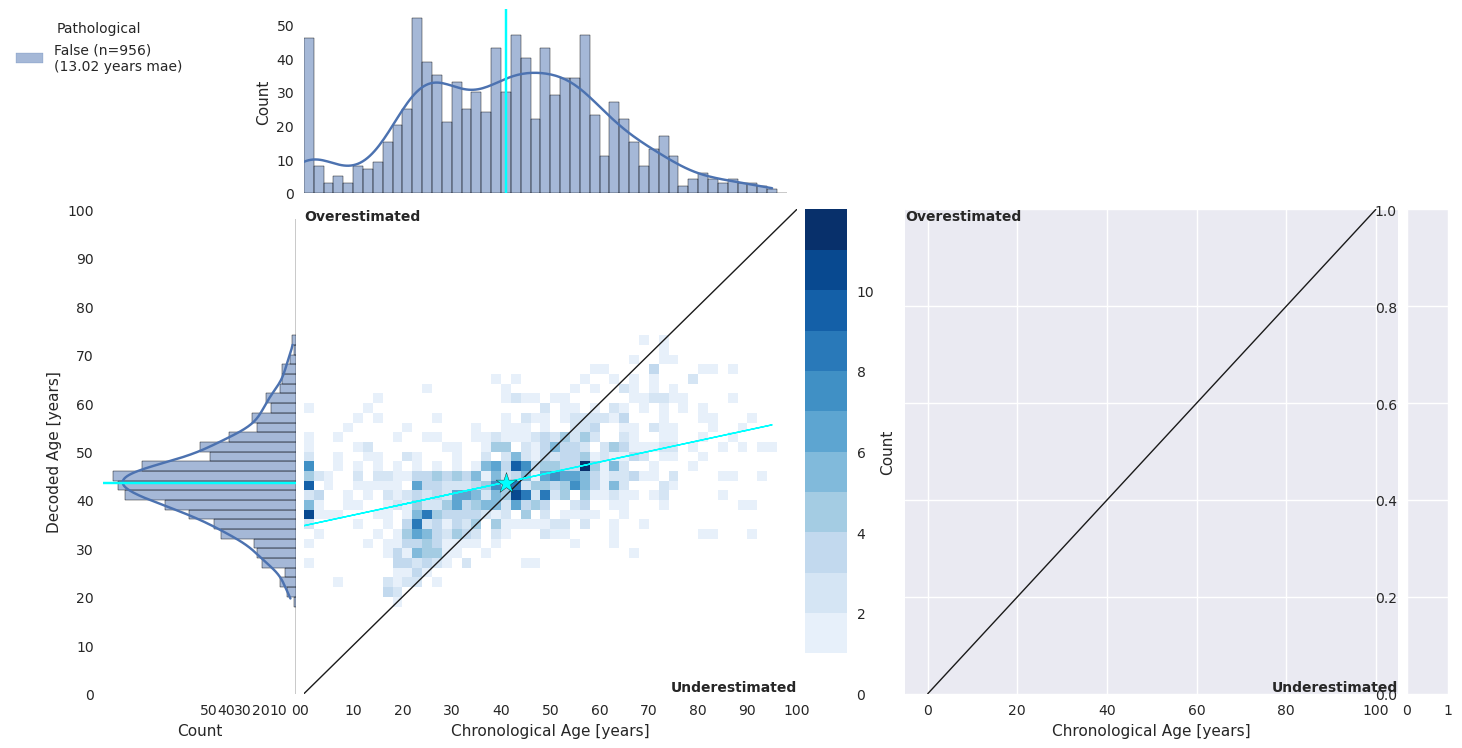

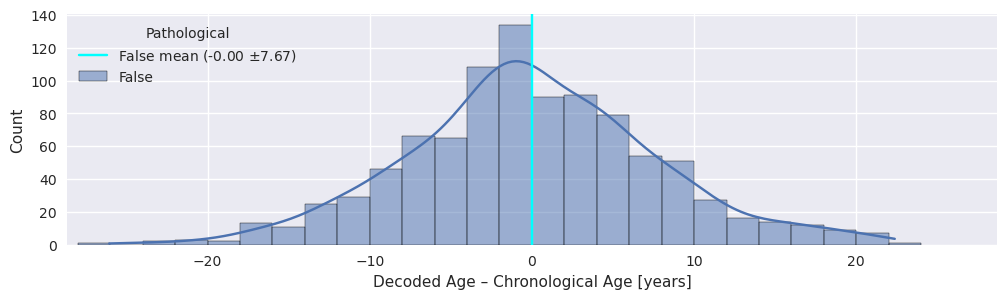

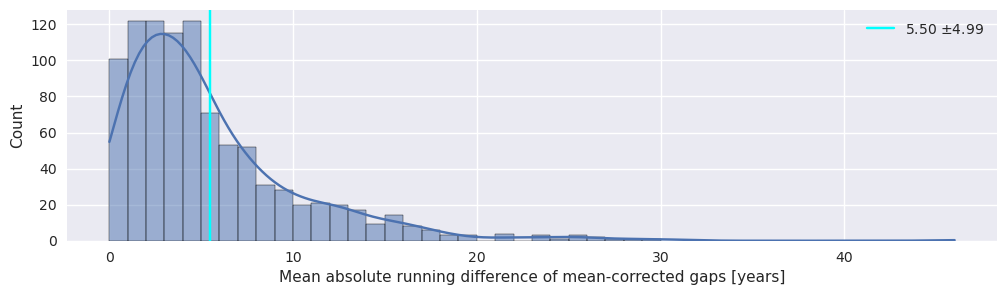

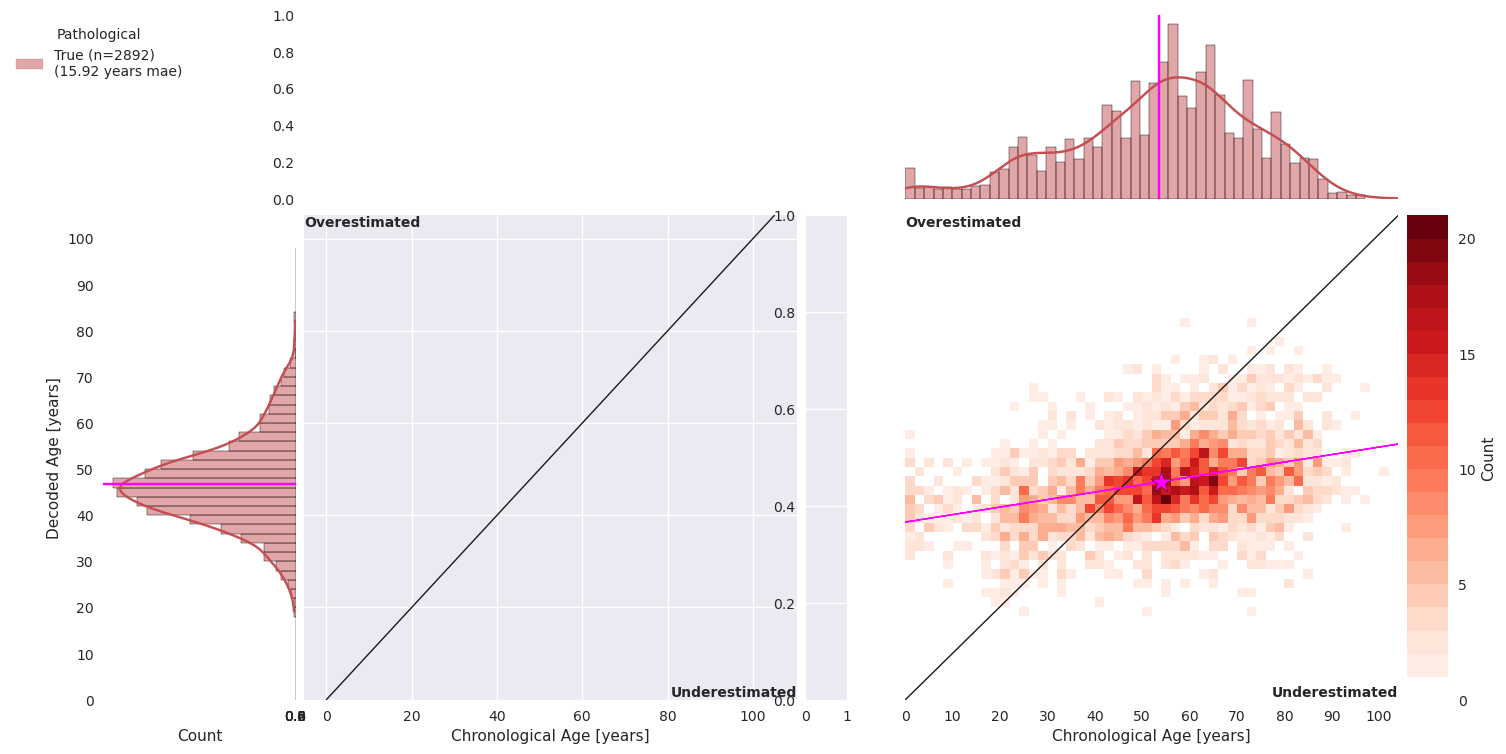

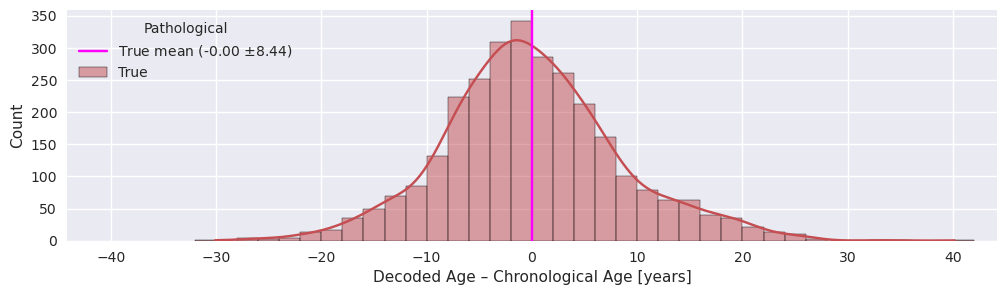

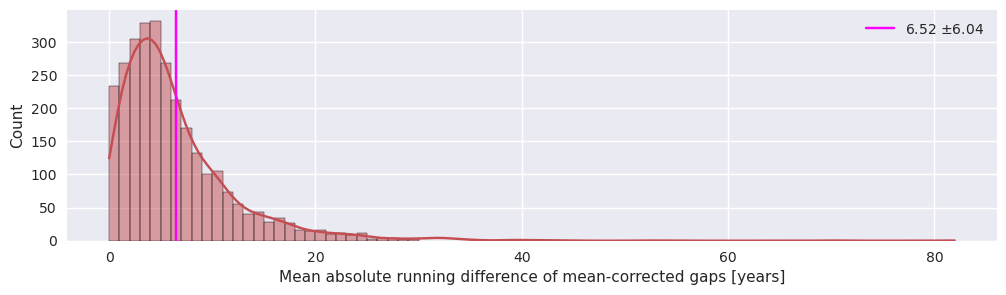

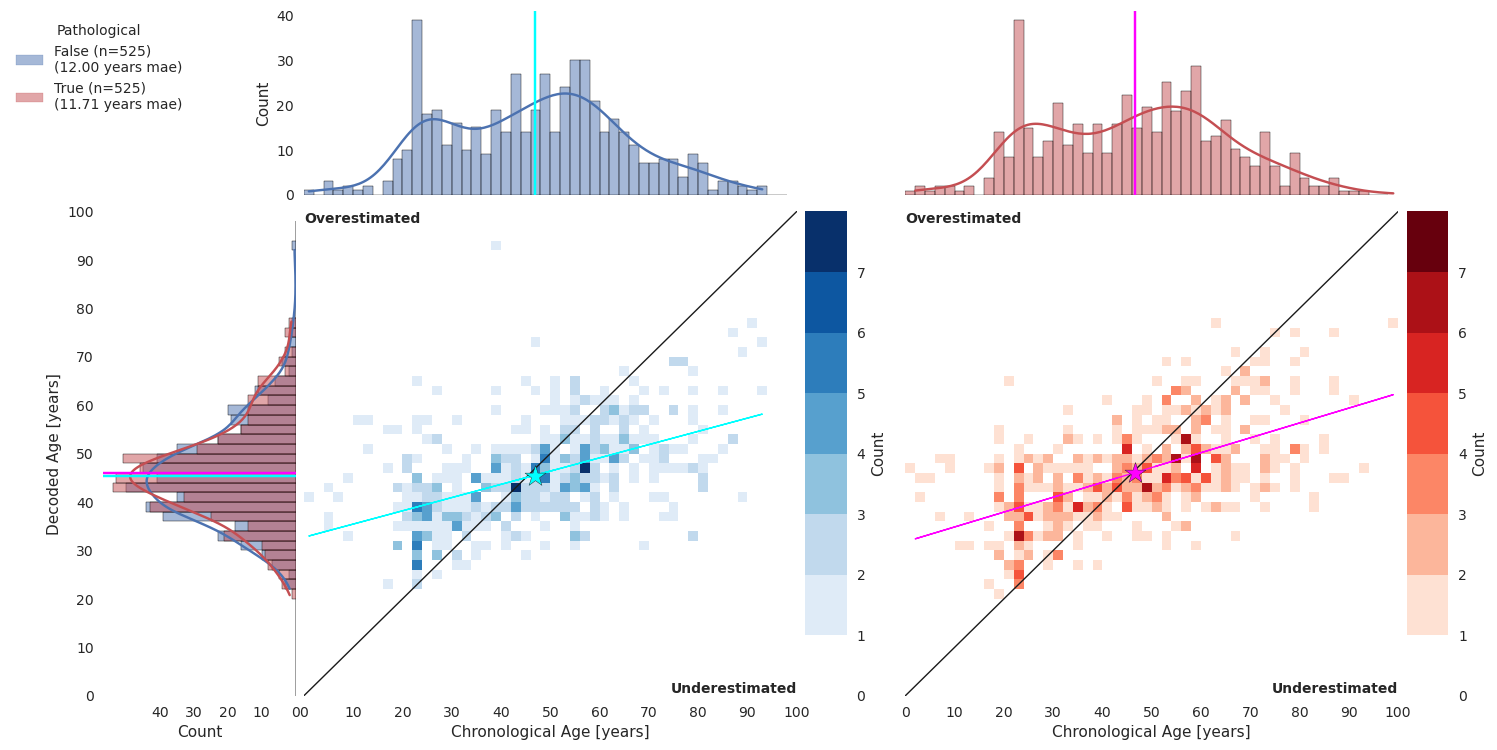

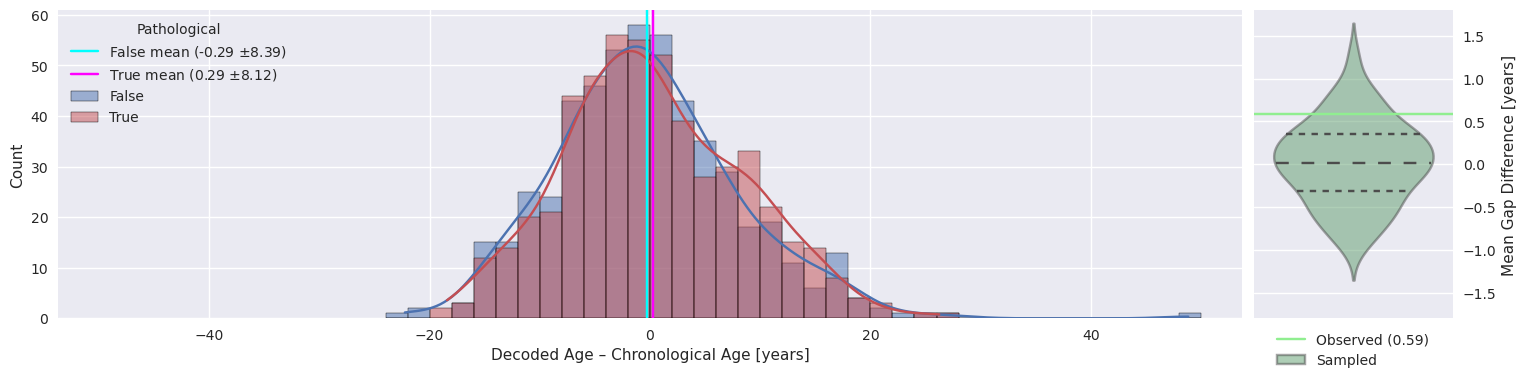

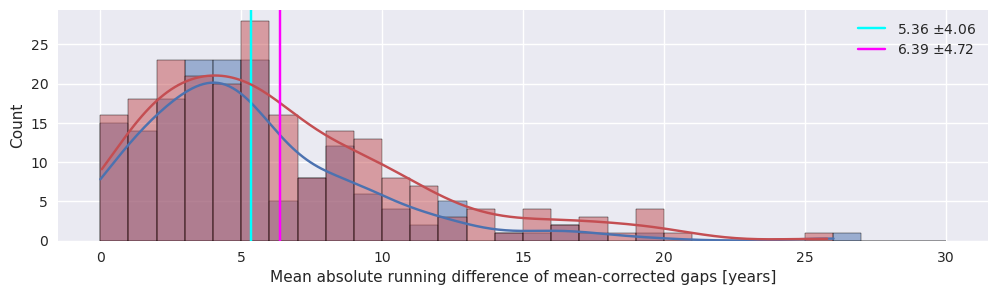

In [10]:
cols = ['y_true', 'y_pred', 'subject', 'pathological']
for ds_name in ['non_pathological', 'pathological', 'transition', ]:#['transition', 'non_pathological', 'pathological']:
    all_preds, configs = [], []
    for i, exp_path in enumerate(iter_exp_dir(exp_dir, exp_date)):
        preds_path = os.path.join(exp_dir, exp_path, 'preds', f'{checkpoint}_longitudinal_{ds_name}_preds.csv')
        try:
            preds = pd.read_csv(preds_path, index_col=0)[cols]
        except:
            continue
        all_preds.append(preds)
    all_preds = pd.concat(all_preds)
    all_preds = all_preds.reset_index().groupby('index').mean().reset_index(drop=True)

    preds_to_plot = all_preds
    if subject_wise:
        all_subject_preds = all_preds.groupby(['pathological', 'subject'], as_index=False).mean()
        preds_to_plot = all_subject_preds
    
    plot_heatmaps(preds_to_plot, bin_width)
    # possible to deconfound here?
    if detrend is not None:
        preds_to_plot = deconfound(preds_to_plot, detrend)
    if ds_name == 'transition':
        plot_age_gap_hist_and_permutation_test(preds_to_plot, bin_width, n_repetitions)
    else:
        plot_age_gap_hist(preds_to_plot, bin_width)
    d = mean_abs_running_diff_of_mean_corrected_gaps(all_preds)
    ax = plot_mean_abs_running_diff_of_mean_corrected_gaps(d)

In [51]:
# TODO: compute patient level gaps and difference, not population level

In [53]:
d = mean_abs_running_diff_of_mean_corrected_gaps(all_preds)

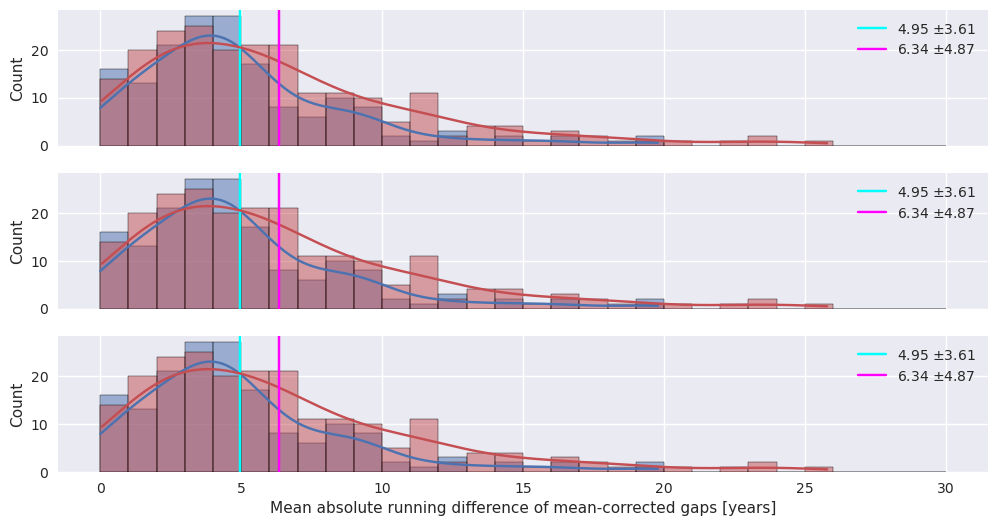

In [55]:
fig, ax_arr = plt.subplots(3, 1, figsize=(12,6), sharex=True, sharey=True)
ax = plot_mean_abs_running_diff_of_mean_corrected_gaps(d, ax_arr[0])
ax = plot_mean_abs_running_diff_of_mean_corrected_gaps(d, ax_arr[1])
ax = plot_mean_abs_running_diff_of_mean_corrected_gaps(d, ax_arr[2])

Text(0.5, 0, 'Recording interval')

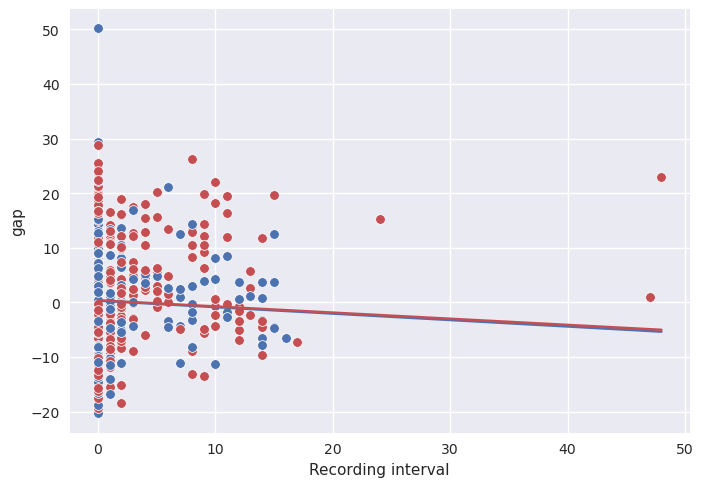

In [15]:
# gap over time diff
import numpy as np

cs = {0: 'b', 1: 'r'}
plotted_values = [] 
patho = []
time = []
for i, ((subject, pathological), g) in enumerate(all_preds.groupby(['subject', 'pathological'])):
    g.sort_values('y_true', inplace=True)
    #g
    g['time'] = g['y_true'].diff().fillna(0).cumsum()
    #g.groupby('time').mean()
    patho.extend(g['pathological'].to_list())
    plotted_values.extend(g['gap'].to_list())
    time.extend(g['time'].to_list())
    sns.scatterplot(data=g.groupby('time').mean(), x='time', y='gap', c=cs[int(pathological)])#, hue='pathological', palette=['r'])
    #if i == 100:
    #    break
    
frame = pd.DataFrame({'time': time, 'gap': plotted_values, 'patho': patho})
for n, g in frame.groupby('patho'):
    m, b = np.polyfit(g['time'], g['gap'], 1)
    ax = sns.lineplot(y=[m*t+b for t in time], x=time, c=cs[int(n)])
ax.set_xlabel('Recording interval')

In [16]:
# further division of transition into 01 and 10

In [17]:
gs_01, gs_10 = [], []
for n, g in all_preds.groupby('subject'):
    if len(g) == 2:
        if g.pathological.iloc[-1] == 0:
            gs_10.append(g)
        else:
            gs_01.append(g)
gs_01 = pd.concat(gs_01)
gs_10 = pd.concat(gs_10)

In [18]:
gs_10

,y_true,y_pred,subject,pathological,gap
154,6.000000,18.298175,320.0,1.0,12.298175
155,9.000000,16.938173,320.0,0.0,7.938173
208,29.000000,27.235033,466.0,1.0,-1.764967
209,42.000000,43.209535,466.0,0.0,1.209534
217,39.000000,32.056569,522.0,1.0,-6.943431
...,...,...,...,...,...
3279,54.000002,52.804663,14284.0,0.0,-1.195339
3285,85.000002,80.458983,14332.0,1.0,-4.541018
3286,85.000002,94.071415,14332.0,0.0,9.071413
3287,33.000001,35.323582,14382.0,1.0,2.323581


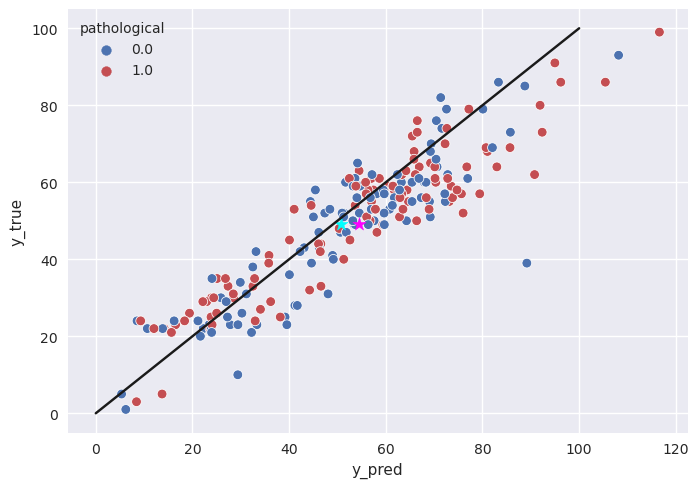

In [19]:
ax = sns.scatterplot(data=gs_01, x='y_pred', y='y_true', hue='pathological', palette=['b', 'r'])
ax.plot([0, 100], [0, 100], c='k')
ax.scatter(gs_01[gs_01['pathological'] == 0]['y_pred'].mean(), gs_01['y_true'].mean(), c='cyan', marker='*', s=100)
ax.scatter(gs_01[gs_01['pathological'] == 1]['y_pred'].mean(), gs_01['y_true'].mean(), c='magenta', marker='*', s=100)

observed age gap diff 0.8117037995828986


<AxesSubplot: xlabel='Decoded Age – Chronological Age [years]', ylabel='Count'>

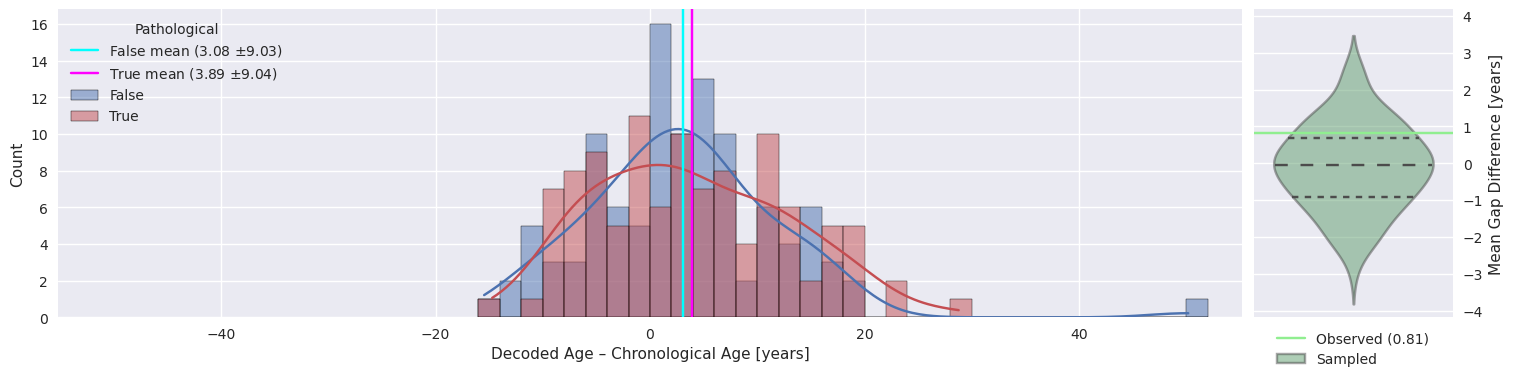

In [20]:
plot_age_gap_hist_and_permutation_test(gs_01, bin_width, n_repetitions)

observed age gap diff 0.6460305474124035


<AxesSubplot: xlabel='Decoded Age – Chronological Age [years]', ylabel='Count'>

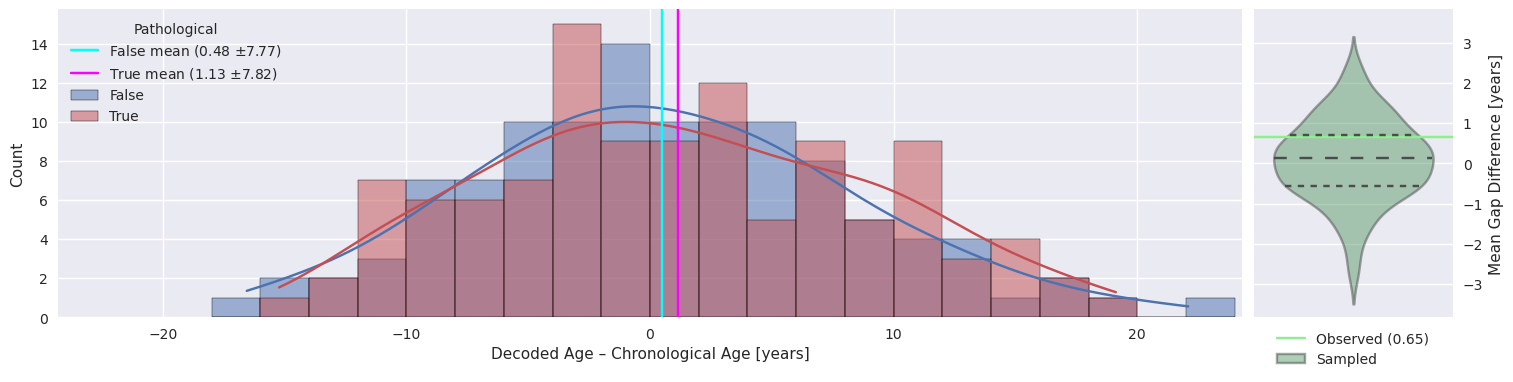

In [21]:
plot_age_gap_hist_and_permutation_test(gs_10, bin_width, n_repetitions)

In [117]:
# compute subject wise difference
all_preds['gap'] = all_preds.y_pred-all_preds.y_true
f = all_preds.groupby('subject').diff()
(f[pd.isna(f).sum(axis=1) == 0])['gap'].abs().mean()

5.470080030036041

In [118]:
# compute subject wise difference
diffs = all_preds.groupby('subject').diff()
diffs = diffs[pd.isna(diffs).sum(axis=1) == 0]
(diffs.y_pred - diffs.y_true).abs().mean()

5.470080030036041

In [42]:
import numpy as np

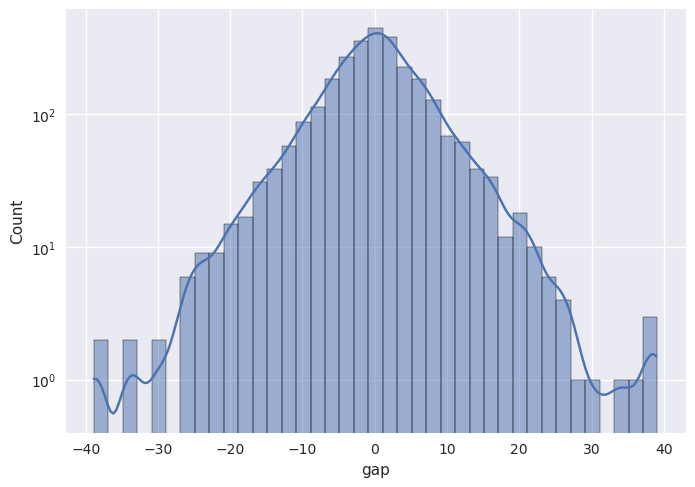

In [49]:
ax = sns.histplot(data=diffs, x='gap', binwidth=2, kde=True)
#ax.axvline((diffs.y_pred - diffs.y_true).abs().mean())
ax.set_yscale('log')

In [24]:
import seaborn as sns

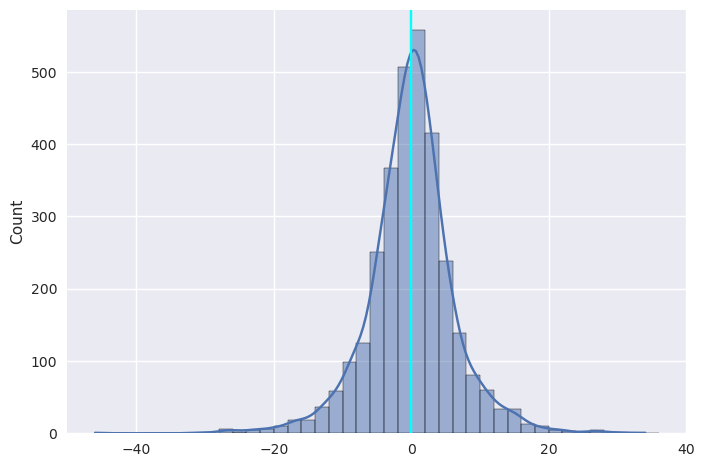

In [25]:
ax = sns.histplot((diffs.y_pred-diffs.y_true), binwidth=2, kde=True)
ax.axvline((diffs.y_pred - diffs.y_true).mean(), c='cyan')

In [10]:
import seaborn as sns

In [11]:
import matplotlib.pyplot as plt

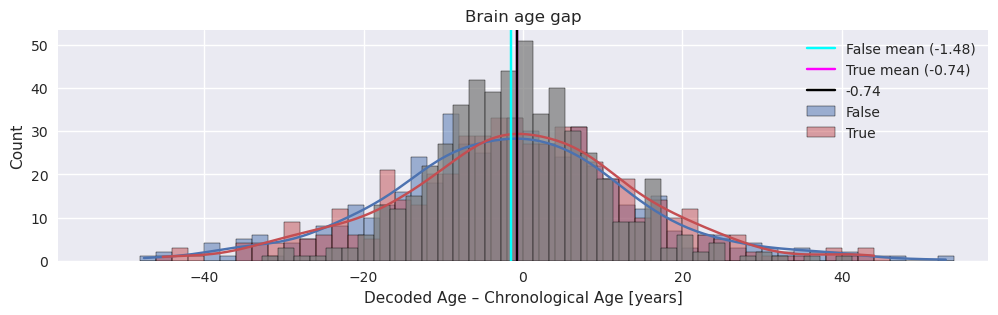

In [82]:
ax = plot_age_gap_hist(all_preds, bin_width)

subject_wise_gaps = []
for s, g in all_preds.groupby('subject'):
    gap = (g.y_pred - g.y_true)[::-1].diff().tail(1)
    subject_wise_gaps.append(gap)
subject_wise_gaps = pd.concat(subject_wise_gaps)

#fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax = sns.histplot(subject_wise_gaps, ax=ax, color='grey', binwidth=bin_width)
#ax = sns.histplot(data=all_preds, x=gap, hue='pathological', ax=ax)
ax.axvline(subject_wise_gaps.mean(), c='black', label=f'{subject_wise_gaps.mean():.2f}')
ax.legend()

In [15]:
from decode_tueg import reject_derivating_ages

In [16]:
for ds_i, ds_ in enumerate(ds.datasets):
    break

In [18]:
_ = [ds_.set_description(
    {'path': ds_.description['path'].replace(
        '/data/datasets/TUH/EEG/tuh_eeg', '/home/jovyan/mne_data/TUH/tuh_eeg/')},
    overwrite=True,
) for ds_i, ds_ in enumerate(ds.datasets)]